# Predicting Invasive Ductal Carcinoma from tissue slides using Machine Learning

# Table of contents
1. [What is Invasive Ductal Carcinoma?](#introduction)
2. [What is the goal of this notebook?](#goal)
3. [Setting up the environment](#paragraph1)
    1. [Libraries](#paragraph1a)
    2. [Loading in the data](#paragraph2a)
4. [Exploring the data](#paragraph2)
    1. [Visualizing tissue slides](#paragraph2a)
    2. [Visualizing whole slide](#paragraph2b)
    3. [Identifying dataset imbalances](#paragraph2c)
5. [Machine learning](#paragraph3)
    1. [Create dataset](#paragraph3a)
        1. [Train-test split](#paragraph3a_1)
        2. [Data input, preprocessing and augmentation](#paragraph3a_2)
    2. [Pytorch models](#paragraph3b)
        1. [3-layer CNN](#paragraph3c_1)
        2. [PreTrained Resnet18](#paragraph3c_2)
6. [ToDo](#paragraph3c)

## What is Invasive Ductal Carcinoma? <a name="introduction"></a>

Invasive Ductal Carcinoma (IDC) is the most common type of breast cancer. About 80% of all breast cancers are invasive ductal carcinomas. Ductal means that the cancer began in the milk ducts (A) of the breast which function as pipes that carry the milk from the lobules (B) to the nipple (D). Carcinomas is a type of cancer that starts in cells that make up the skin or the tissue lining of organs, such as breast tissue. Invasive ductal carcinoma in contrast to ductal carcinoma in situ refers to the invasive nature of the tumor into the surrounding breast tissues. IDCs are a heterogenous group of tumors with high morphological variations and are normally classified into histopathological subtypes according to a wide range of criteria, including cell type (as in apocrine carcinoma), amount, type and location of secretion (as in mucinous carcinoma), architectural features (as in papillary, tubular, and micropapillary carcinoma), and immunohistochemical profile (as in neuroendocrine carcinoma). Over time, IDCs can spread to lymph nodes and possibly other areas of the body. Treatments for IDCs include surgery, chemotherapy, radiation therapy, hormonal therapy, and targeted therapy.


![Figure 1](https://raw.githubusercontent.com/Douwe-Spaanderman/IDCfromHistoPathology/main/docs/fig1.jpg)

ref: Diversity of Breast Carcinoma: Histological Subtypes and Clinical Relevance

## What is the goal of this notebook? <a name="goal"></a>

In this notebook a dataset of the paper: "Automatic detection of invasive ductal carcinoma in whole slide images with Convolutional Neural Networks", which consists of histopathology images from patients with IDC patients, is used to play around with and assess the methods used in the paper and improve upon them with hopefully better results. Also becomming more familiar with IDC histopathology along the way.

In the paper, they achieved the following results by using a 3-layer convolutional network:

| | Precision | Recall | Specificity | F-measure | Balanced Accuracy |
| --- | --- | --- | --- | --- | --- |
| CNN | 0.6540 | 0.7960 | 0.8886 | 0.7180 | 0.8423 | 

I want to reassess this model by building it from scratch, look into weaknesses of the dataset and use more state of the art models ... well atleast the models that my laptop can handle. Also as I side goal, I am familair with Tensorflow and Keras however I have never used pytorch before, looks interesting!

## Setting up the environment <a name="paragraph1"></a>

### Libraries <a name="paragraph1a"></a>

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image

# ML
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Utils
import os
from pathlib import Path
import random
import re
from collections import Counter

# Setting up paths
p = Path('./data/IDC_regular_ps50_idx5/')
p_out = Path('./model/')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Loading in the data <a name="paragraph2a"></a>

Lets check how many folder (patients) we have in our directory

In [2]:
listofsubdirectories = [x for x in p.iterdir() if x.is_dir()]
print(len(listofsubdirectories))

279


Now ideally for a project like this you would like to have more data, however as we are predicting only 2 classes (normal and IDC) and it is a public dataset it should do. Also to note, we have slightly more data (+39 patients) than was reported in the paper so we would most likely already be able to provide better results with their own model.

Now lets create a metatable with patient ID, path in glob and diagnosis. Looking at the shape of the dataframe we can find the number of images which will be the actually input of the model:

In [3]:
# Create metadata table Patient ID | Path | normal or IDC
row_data = []
for subdirectory in listofsubdirectories:
    for diagnosis in [0,1]:
        images = list(subdirectory.glob(f'{diagnosis}/*.png'))
        for image in images:
            row_dict = {}
            row_dict["Patient ID"] = subdirectory.stem
            row_dict["IDC"] = diagnosis
            row_dict["Path"] = image
            row_data.append(row_dict)
    
metadata = pd.DataFrame(row_data)  

In [4]:
metadata.shape

(277524, 3)

## Exploring the data <a name="paragraph2"></a>

### Visualizing tissue slides <a name="paragraph2a"></a>

To get a better understanding of the data we will select some random cancer and normal tissue slides for visualization. As shown below, figures are 50px by 50px in RGB.

In [5]:
# Randomly pick a number of normal and IDC slides
neg = np.random.choice(metadata[metadata["IDC"] == 0]["Path"], 20)
pos = np.random.choice(metadata[metadata["IDC"] == 1]["Path"], 20)

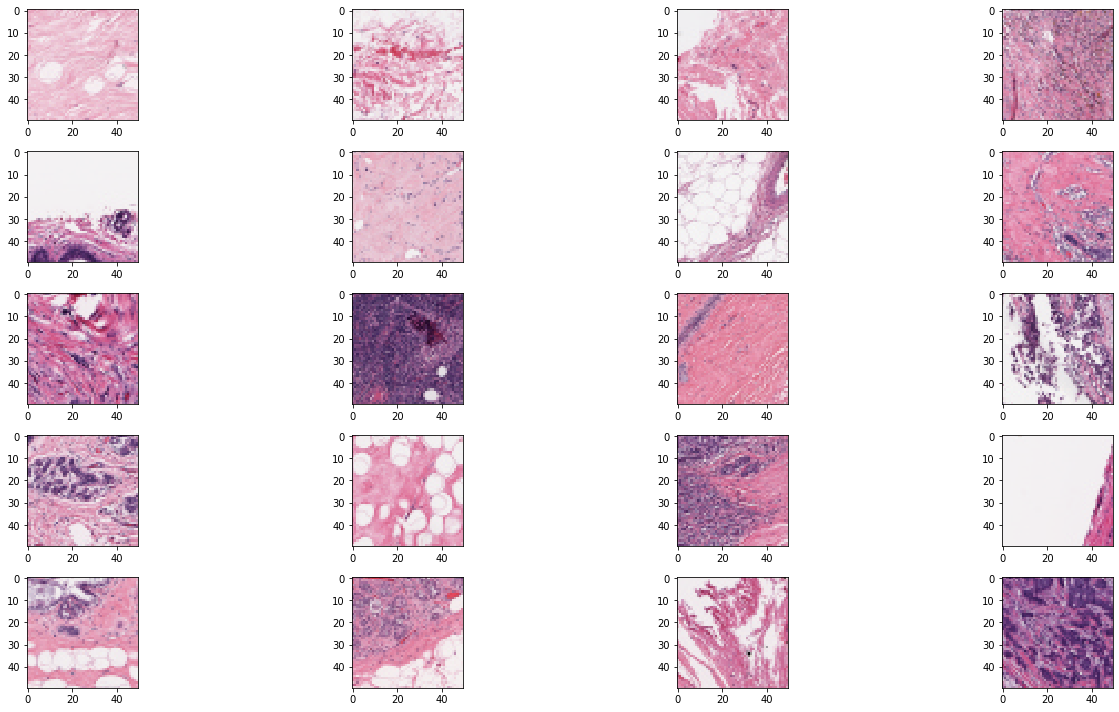

In [6]:
fig, ax = plt.subplots(5, 4, figsize=(20,10))

j = 0
i = 0
for negative in neg:
    img = imread(str(negative))
    ax[i,j].imshow(img)
    ax[i,j].grid(False)
    if i == 4:
        j += 1
        i = 0
    else:
        i += 1
        
fig.tight_layout()
plt.show()

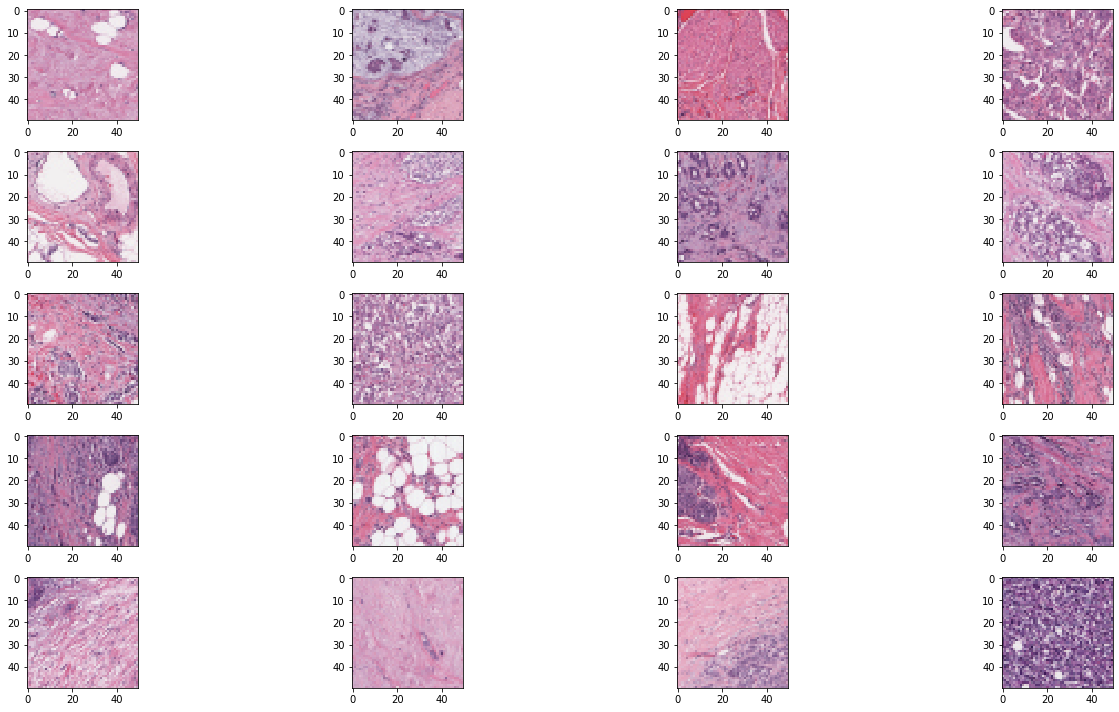

In [7]:
fig, ax = plt.subplots(5, 4, figsize=(20,10))

j = 0
i = 0
for positive in pos:
    img = imread(str(positive))
    ax[i,j].imshow(img)
    ax[i,j].grid(False)
    if i == 4:
        j += 1
        i = 0
    else:
        i += 1
        
fig.tight_layout()
plt.show()

### Visualizing whole slide <a name="paragraph2b"></a>

The dataset only provides these small tissue slides without giving an overview of the bigger picture. Here I want to combine pictures based on their Y and X coordinates (provided in the name) in a patient overview. Thereby we can see if everything is given by the dataset or if we are missing valuable information

In [8]:
# The dataset only provides small tissue slides - Transform X and Y coordinates to overall picture
def patient_whole_slide(metadata, patient_id):
    patient_data = metadata[metadata["Patient ID"] == patient_id]
    
    # Lets find for each image the y and x coordinates in the name of the file, note coordinates -1
    patient_data.loc[:, "X_coordinates"] = patient_data.loc[:, "Y_coordinates"] = 0
    patient_data.loc[:, ["X_coordinates", "Y_coordinates"]] = [[int(k[1:])-1 for k in re.split('/|_',str(x))[9:-1]] for x in patient_data["Path"]]
    
    # Create two arrays filled with ones and zero's for max coordinates to create an image array and a diagnosis overlay
    y_max = patient_data["Y_coordinates"].max()
    x_max = patient_data["X_coordinates"].max()
    image = 255 * np.ones(shape = (y_max + 50, x_max + 50, 3)).astype(np.uint8)
    overlay = 255 * np.ones(shape = (y_max + 50, x_max + 50, 3)).astype(np.uint8)
    
    # Fill array by looping over images
    cache_shape = []
    for index, row in patient_data.iterrows():
        img = imread(str(row["Path"]))
        
        # Fill image based on coordinates
        y_start = row["Y_coordinates"]
        x_start = row["X_coordinates"]
        
        # Normally + 50 would work, however some have other shapes lets shave those
        if img.shape[0] != 50 & img.shape[1] != 50:
            cache_shape.append(row)
    
        image[y_start:y_start+img.shape[0], x_start:x_start+img.shape[1]] = 255 * img

        # Overlay the diagnosis by filling red, other rgb have to be filled for white
        if row["IDC"] == 1:
            overlay[y_start:y_start+img.shape[0], x_start:x_start+img.shape[1], 0] = 200
            overlay[y_start:y_start+img.shape[0], x_start:x_start+img.shape[1], 1] = 0
            overlay[y_start:y_start+img.shape[0], x_start:x_start+img.shape[1], 2] = 0
    
    if cache_shape:
        cache_shape = pd.concat(cache_shape)
    
    return image, overlay, cache_shape

In the first slide we can see a 'good' example of a compleet tissue slide with annotation. However, the second example shows you that not everything in the data is compleet unfortunately

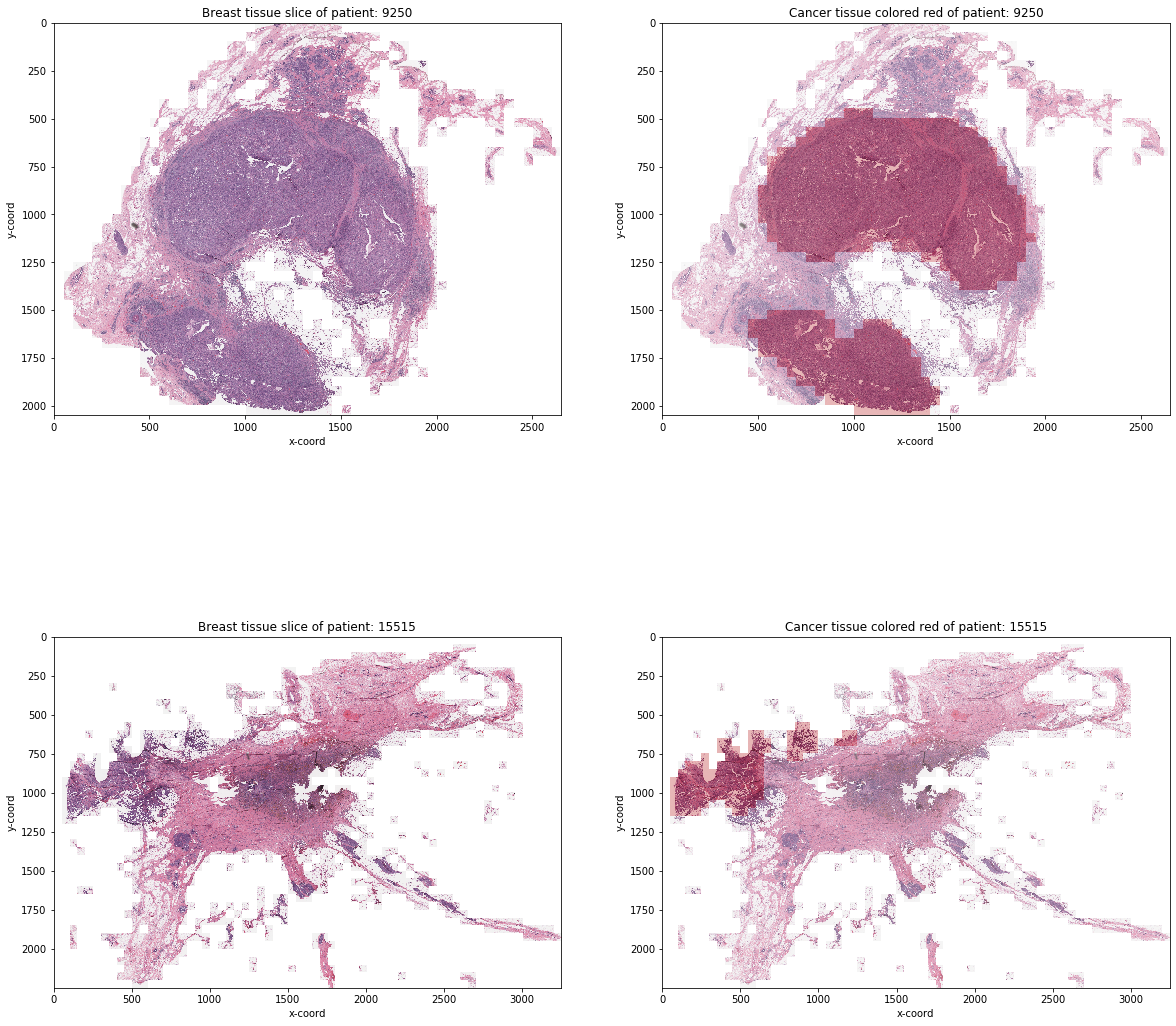

In [9]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
patients_id = ["9250", "15515"]
for i in range(2):
    # We can pick a random one using this function
    #patient_id = random.choice(metadata["Patient ID"].unique())
    
    # For illustration purposes I have picked two
    patient_id = patients_id[i]
    
    image, overlay, cache_shape = patient_whole_slide(metadata, patient_id)
    
    ax[i,0].imshow(image, alpha=0.9)
    ax[i,1].imshow(overlay, alpha=0.8)
    ax[i,1].imshow(image, alpha=0.7)
    ax[i,0].grid(False)
    ax[i,1].grid(False)
    for m in range(2):
        ax[i,m].set_xlabel("x-coord")
        ax[i,m].set_ylabel("y-coord")
        
    ax[i,0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[i,1].set_title("Cancer tissue colored red of patient: " + patient_id)

### Identifying dataset imbalances <a name="paragraph2c"></a>

As visualized we can see that there is a class imbalance between the number of normal vs tumor tissue sections. WE have to take note of this imbalance for now. A neat way of solving this could be using downsampling, creating an equal number of tumor and normal test samples. Ofcourse this would mean that we have less samples to train on, possible hurting our model. In the paper they used a balanced accuracy measurement to account for this imbalance. I will use this same measurement first before assessing downsampling.

Additionally number of images (50x50 sections) is different for patients, i.e. some patients having more data than others. This could cause overfitting issue where data is abundant.

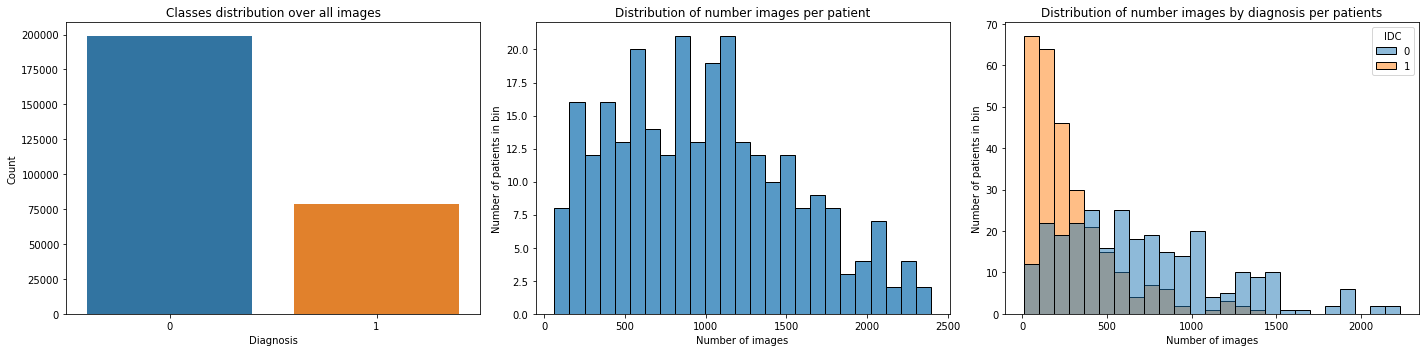

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

sns.countplot(x="IDC", data=metadata, ax=ax[0])

sns.histplot(x="Path", data=metadata.groupby(["Patient ID"]).count(), ax=ax[1], bins=25)
sns.histplot(x="Path", data=metadata.groupby(["Patient ID", "IDC"]).count(), hue="IDC", ax=ax[2], bins=25)

ax[0].set_title("Classes distribution over all images")
ax[0].set_xlabel("Diagnosis")
ax[0].set_ylabel("Count")
ax[1].set_title("Distribution of number images per patient")
ax[1].set_xlabel("Number of images")
ax[1].set_ylabel("Number of patients in bin")
ax[2].set_title("Distribution of number images by diagnosis per patients")
ax[2].set_xlabel("Number of images")
ax[2].set_ylabel("Number of patients in bin")

fig.tight_layout()
plt.show()

## Machine learning <a name="paragraph3"></a>

### Create dataset <a name="paragraph3a"></a>

#### Train-test split <a name="paragraph3a_1"></a>

Test - Training split should be done on the patient level and not on the tissue slide level as otherwise the test set wouldn't be as independent of the training set as one might think. The paper uses a train - val - test split of 67,5 - 12,5 - 20.

Again as there is class imbalance in this dataset we can use downsampling to create an equal number of normal and IDC samples in the dataset. Also the distribution of images per patient is different and could also be included to create a better test - train split.

In [11]:
def train_test_split(metadata, imbalance=False):
    patient_id = list(metadata["Patient ID"].unique())
    random.shuffle(patient_id)
    train_index, validate, test = np.split(patient_id, [int(.675*len(patient_id)), int(.8*len(patient_id))])
    
    if imbalance == True:
        # Downsampling on every patient
        train = []
        for patient in train_index:
            train_tmp = metadata[metadata["Patient ID"] == patient]
            count_items = Counter(train_tmp["IDC"])
            max_count = max(count_items, key=count_items.get)
            min_count = 1-max_count
            min_df = train_tmp[train_tmp["IDC"] == min_count]
            max_df = train_tmp[train_tmp["IDC"] == max_count].sample(n=len(min_df))
            
            train.append(pd.concat([min_df, max_df]))
            
        train = pd.concat(train)
    else:
        train = metadata[metadata["Patient ID"].isin(train_index)]
        
    validate = metadata[metadata["Patient ID"].isin(validate)]
    test = metadata[metadata["Patient ID"].isin(test)]
    
    return train, validate, test

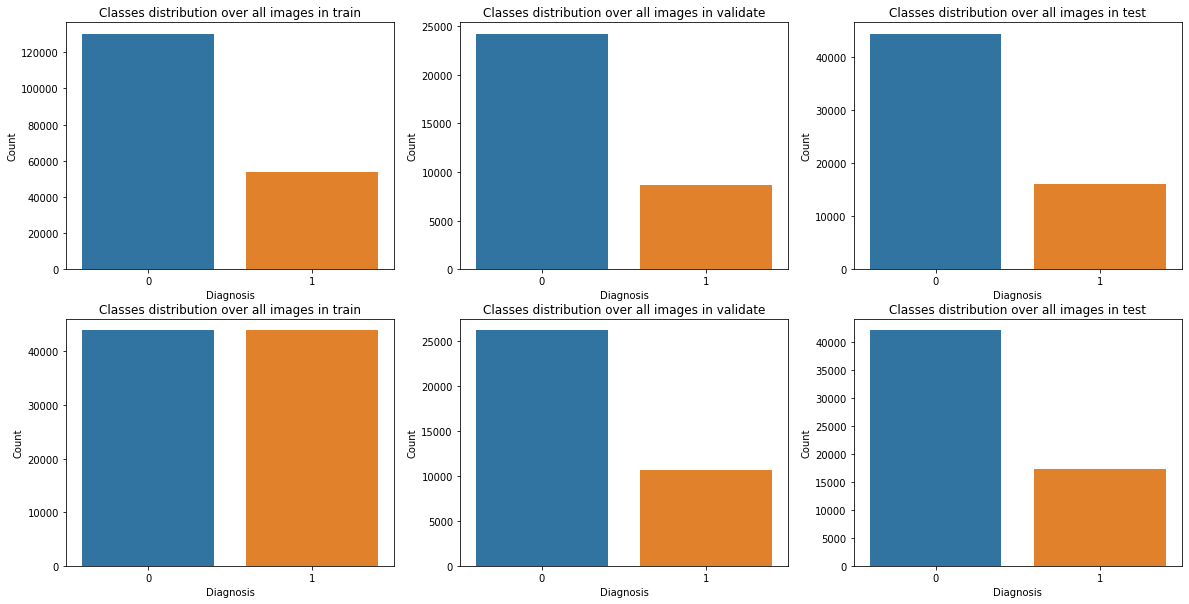

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

imbalance = [False, True]
for i in range(2):
    train, validate, test = train_test_split(metadata, imbalance[i])
    data = [train, validate, test]
    for j in range(3):
        sns.countplot(x="IDC", data=data[j], ax=ax[i,j])
        name = ["train", "validate", "test"][j]
        ax[i,j].set_title(f"Classes distribution over all images in {name}")
        ax[i,j].set_xlabel("Diagnosis")
        ax[i,j].set_ylabel("Count")

It is good to note that there are no major differences in the imbalance of the classes between the 3 sets. Also we see how downsampling works for limiting the number of normal samples in the training data at the cost of data points.

#### Data input, preprocessing and augmentation <a name="paragraph3a_2"></a>

In order to easily load in and transform data I am using the Dataloader and Dataset from pytorch following this [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Thereby easily storing all the data including coordinates and patient ID.

Noteworthy, as described by the paper RGB is converted to YUV color and normalized to a mean of zero and variance of one (this is given as an option preprocessing). This step removes correlations of raw pixels, allowing to focus on properties that are not dependent on covariances, such as sparseness. The motivation to do that are to accentuate differences between input features and accelerate gradient-based learning.

In [13]:
# Preprocessing
def rgb2yuv(rgb):
    m = np.array([
        [0.29900, -0.147108,  0.614777],
        [0.58700, -0.288804, -0.514799],
        [0.11400,  0.435912, -0.099978]
    ])
    yuv = np.dot(rgb, m)
    yuv[:,:,1:] += 0.5
    return yuv

def preprocessing(image):
    image = rgb2yuv(image)
    image = (image - image.mean(axis=0)) / image.std(axis=0)
    
    return image

Unlike the paper we do some figure augmentations by rotating the figures. As the training data is used as individual segments and not as slides from a whole image, i.e. no spatial dependencies between the slides, we can change the rotation of the images. Also make sure every figure is of size 50px by 50px.

In [14]:
transform_train = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
])

transform_plot = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [15]:
class IDCdata(Dataset):
    def __init__(self, df, transform=None, preprocessing=None):
        self.data = df
        self.preprocessing = preprocessing
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_df = self.data.iloc[idx]
        Ycoords, Xcoords = [int(k[1:])-1 for k in re.split('/|_',str(sample_df["Path"]))[9:-1]]
        image = Image.open(str(sample_df["Path"]))

        if self.preprocessing:
            image = self.preprocessing(image)
            
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'diagnosis': str(sample_df["IDC"]), 'Patient ID': sample_df["Patient ID"], "Y coords":Ycoords, "X coords":Xcoords}

        return sample

Lets look at what the data figures look like with RGB normal, transformation and preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


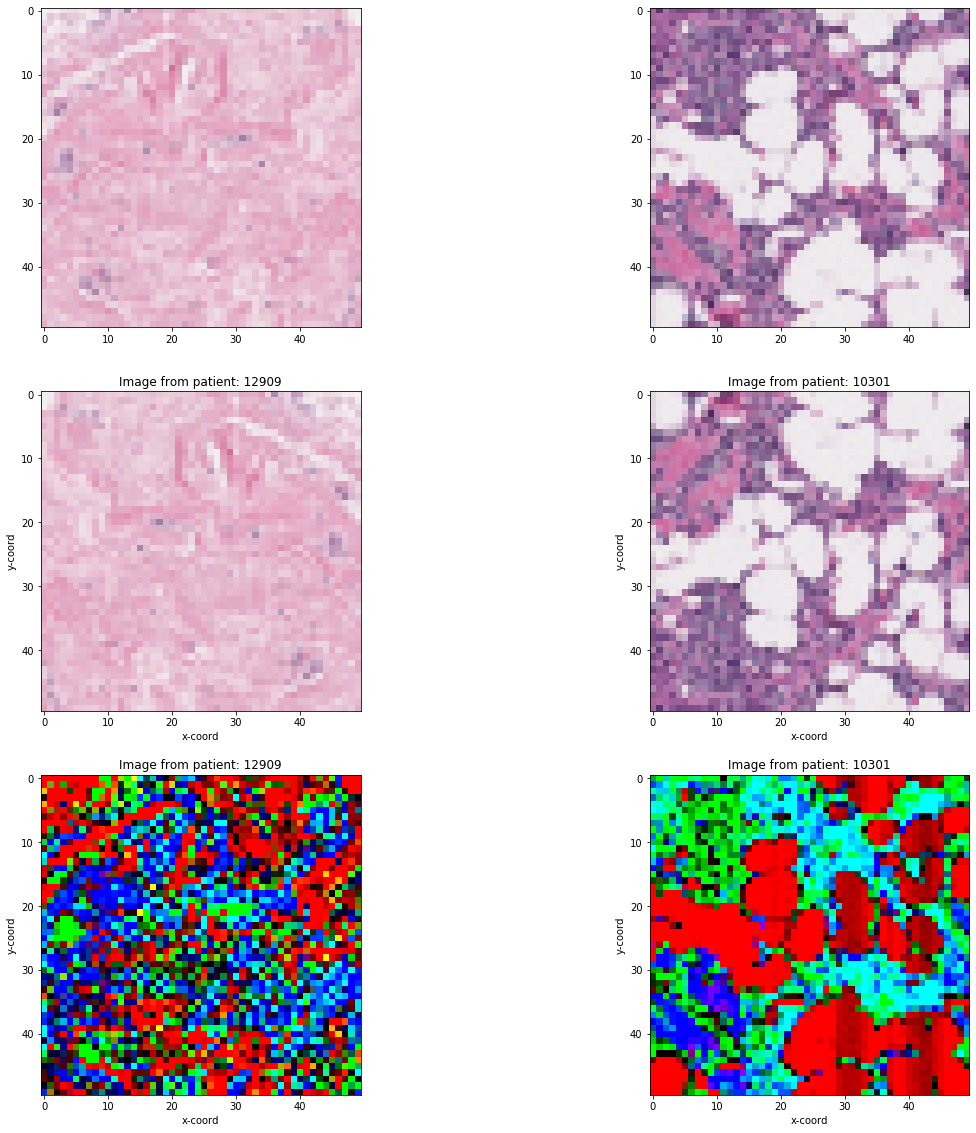

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))

i = 0
train_dataset = IDCdata(train, transform=None , preprocessing=None)
for i in range(2):
    img = train_dataset.__getitem__(i*10000)
    patient = img["Patient ID"]
    ax[0,i].imshow(img["image"])
    ax[0,i].grid(False)
    ax[1,i].set_title(f"Image from patient: {patient}")
    ax[1,i].set_xlabel("x-coord")
    ax[1,i].set_ylabel("y-coord")
    
i = 0
train_dataset = IDCdata(train, transform=transform_plot , preprocessing=None)
for i in range(2):
    img = train_dataset.__getitem__(i*10000)
    patient = img["Patient ID"]
    ax[1,i].imshow(img["image"])
    ax[1,i].grid(False)
    ax[1,i].set_title(f"Image from patient: {patient}")
    ax[1,i].set_xlabel("x-coord")
    ax[1,i].set_ylabel("y-coord")
    
i = 0
train_dataset = IDCdata(train, transform=None , preprocessing=preprocessing)
for i in range(2):
    img = train_dataset.__getitem__(i*10000)
    patient = img["Patient ID"]
    ax[2,i].imshow(img["image"])
    ax[2,i].grid(False)
    ax[2,i].set_title(f"Image from patient: {patient}")
    ax[2,i].set_xlabel("x-coord")
    ax[2,i].set_ylabel("y-coord")

### Pytorch models <a name="paragraph3b"></a>

- 3-layer CNN
- ResNet18 pretrained
- ... To Do

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### 3-layer CNN <a name="paragraph3c_1"></a>

For this model I am trying to mimic the convolution neural network that they made for the paper. Which uses a 3 layer Convolutional Neural Network with two convolutional and pooling layers, a full-connected layer and a logistic regression classifier. Furthermore, the convolution layers are activated using a tanh function and are followed by a pooling layers without overlap. Classification is done using logsoftmax function. Finally, the model is trained using stochastic gradient descent to minimize the Binary Cross-Entropy loss function.

![Figure 2](https://raw.githubusercontent.com/Douwe-Spaanderman/IDCfromHistoPathology/main/docs/fig2.png)

Note that the number of input pixels is slightly different in the paper. In theory I could recreate the whole image and than take non-overlapping pieces in the same dimension, however for now 50px by 50px would do. As the stride and padding is not described in the paper I have to calculate these based on the output size using the following formula:

$O = \frac{W-K+2P}{S}+1$

where $O$ is the output height/length, $W$ is the input height/length, $K$ is the filter size, $P$ is the padding, and $S$ is the stride.


In [18]:
class CNN_3_layer(nn.Module):
    def __init__(self):
        super(CNN_3_layer, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=8),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=8),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(1568, 128),
            nn.Tanh(),
        )
        self.fc2 = nn.Linear(128, 2)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        output = self.fc2(out)
        return output

model = CNN_3_layer().to(device)

Select loss function (Cross Entropy), optimizer (Stochastic Gradient Descent) and the hyperparameters:
- number of epochs
- batch_size
- learning rate

In [19]:
# Hyper parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Already includes softmax for learning but not for test to get probability
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# load data
train, validate, test = train_test_split(metadata)

train_dataset = IDCdata(train, transform=transform_train, preprocessing=None)
val_dataset = IDCdata(validate, transform=transform_test , preprocessing=None)
test_dataset = IDCdata(test, transform=transform_test , preprocessing=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [20]:
# CNN model training
def training_model(train_loader, val_loader, model):

    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []

    for epoch in range(num_epochs):
        for i, data  in enumerate(train_loader):
            images = data["image"].to(device)

            # Note should be in dataclass
            labels = [int(x) for x in data["diagnosis"]]
            labels = torch.LongTensor(labels).to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1

            if count % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through validation dataset
                for val_data in val_loader:

                    test = val_data["image"].to(device)
                    # Note should be in dataclass
                    labels = [int(x) for x in val_data["diagnosis"]]
                    labels = torch.LongTensor(labels).to(device)

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)

            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
                
    return model, count, loss_list, iteration_list, accuracy_list

In [21]:
model, count, loss_list, iteration_list, accuracy_list = training_model(train_loader, val_loader, model)

Iteration: 500  Loss: 0.5653441548347473  Accuracy: 80.93920135498047 %
Iteration: 1000  Loss: 0.5712643265724182  Accuracy: 80.89684295654297 %
Iteration: 1500  Loss: 0.5926393270492554  Accuracy: 80.84037017822266 %
Iteration: 2000  Loss: 0.5674103498458862  Accuracy: 80.93920135498047 %
Iteration: 2500  Loss: 0.5560406446456909  Accuracy: 79.12065887451172 %
Iteration: 3000  Loss: 0.4305339455604553  Accuracy: 77.48567199707031 %
Iteration: 3500  Loss: 0.5068302750587463  Accuracy: 78.855224609375 %
Iteration: 4000  Loss: 0.4953376054763794  Accuracy: 78.73944854736328 %
Iteration: 4500  Loss: 0.4327057898044586  Accuracy: 78.22833251953125 %
Iteration: 5000  Loss: 0.45976436138153076  Accuracy: 79.44258117675781 %
Iteration: 5500  Loss: 0.43111252784729004  Accuracy: 79.98192596435547 %
Iteration: 6000  Loss: 0.4561247229576111  Accuracy: 79.16584014892578 %
Iteration: 6500  Loss: 0.4351872503757477  Accuracy: 78.50224304199219 %
Iteration: 7000  Loss: 0.3404580056667328  Accuracy:

It hurts how much the learning process already slowed down my computer so I won't train much deeper models than this. I do might be able to squeeze out a pretrained models

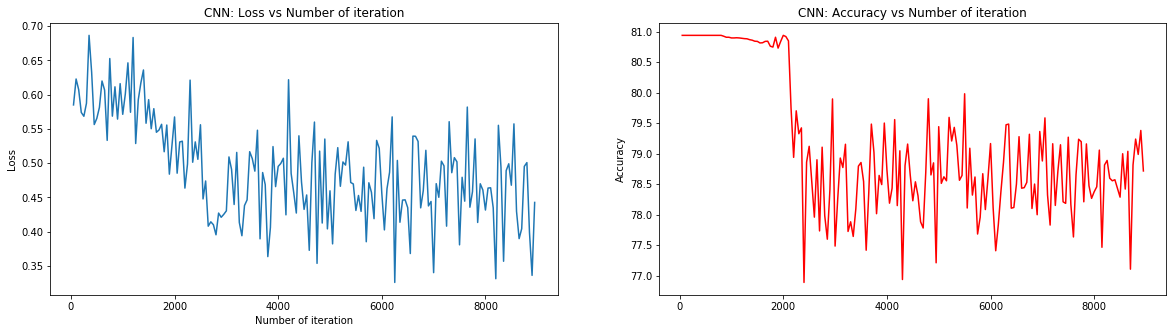

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# visualization loss 
ax[0].plot(iteration_list,loss_list)
ax[0].set_xlabel("Number of iteration")
ax[0].set_ylabel("Loss")
ax[0].set_title("CNN: Loss vs Number of iteration")

# visualization accuracy 
ax[1].plot(iteration_list,accuracy_list,color = "red")
ax[1].set_ylabel("Number of iteration")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("CNN: Accuracy vs Number of iteration")

plt.show()

#### PreTrained Resnet18 <a name="paragraph3c_2"></a>

Pretrained network Resnet18. Further extented using two feed forward layers number of features output to 256 to 2. With Relu activation function, batchnormalization and dropout.

![Figure 3](https://raw.githubusercontent.com/Douwe-Spaanderman/IDCfromHistoPathology/main/docs/fig3.png)

In [23]:
resnet18 = models.resnet18(pretrained=True)

# We need to add two fc layers and included batchnormalization and dropout
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, 2)
)

resnet18 = resnet18.to(device)s

In [24]:
# Hyper parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Already includes softmax for learning but not for test to get probability
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# load data
train, validate, test = train_test_split(metadata)

train_dataset = IDCdata(train, transform=transform_train, preprocessing=None)
val_dataset = IDCdata(validate, transform=transform_test , preprocessing=None)
test_dataset = IDCdata(test, transform=transform_test , preprocessing=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [25]:
model2, count2, loss_list2, iteration_list2, accuracy_list2 = training_model(train_loader, val_loader, model)

Iteration: 500  Loss: 0.38493233919143677  Accuracy: 81.67489624023438 %
Iteration: 1000  Loss: 0.4779130518436432  Accuracy: 82.54789733886719 %
Iteration: 1500  Loss: 0.4307047128677368  Accuracy: 82.73870086669922 %
Iteration: 2000  Loss: 0.5060442090034485  Accuracy: 82.84586334228516 %
Iteration: 2500  Loss: 0.3754357099533081  Accuracy: 82.66551971435547 %
Iteration: 3000  Loss: 0.46622809767723083  Accuracy: 82.79620361328125 %
Iteration: 3500  Loss: 0.40778809785842896  Accuracy: 82.69949340820312 %
Iteration: 4000  Loss: 0.5033954381942749  Accuracy: 82.83279418945312 %
Iteration: 4500  Loss: 0.39457786083221436  Accuracy: 82.89029693603516 %
Iteration: 5000  Loss: 0.5529291033744812  Accuracy: 82.96610260009766 %
Iteration: 5500  Loss: 0.40689563751220703  Accuracy: 82.83802795410156 %
Iteration: 6000  Loss: 0.5046830773353577  Accuracy: 82.45641326904297 %
Iteration: 6500  Loss: 0.5162848234176636  Accuracy: 83.01837158203125 %
Iteration: 7000  Loss: 0.3860523998737335  Accu

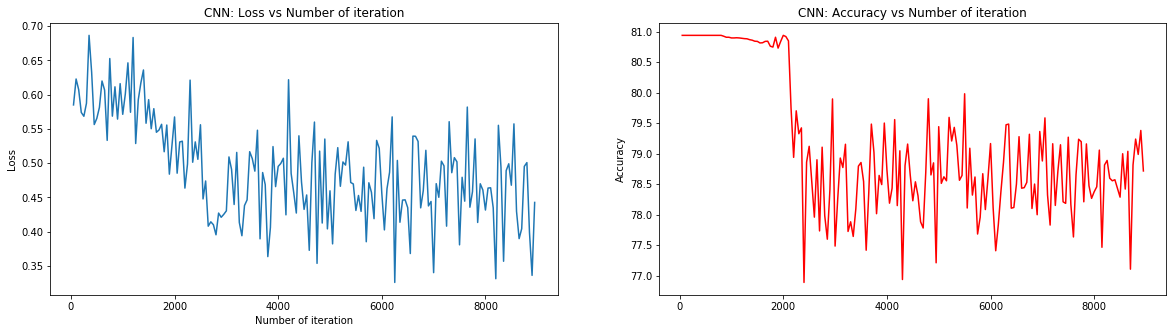

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# visualization loss 
ax[0].plot(iteration_list,loss_list)
ax[0].set_xlabel("Number of iteration")
ax[0].set_ylabel("Loss")
ax[0].set_title("CNN: Loss vs Number of iteration")

# visualization accuracy 
ax[1].plot(iteration_list,accuracy_list,color = "red")
ax[1].set_ylabel("Number of iteration")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("CNN: Accuracy vs Number of iteration")

plt.show()

## ToDo <a name="paragraph3c"></a>

- Test plotting + proba overlay 
- Grid search hyperparameters, such as learning rates
- Cross validation split
- Interesting to do CNN from scratch. I have done this with [Deeper neural network](https://htmlpreview.github.io/?https://github.com/Douwe-Spaanderman/DeepLearningCourse/blob/main/html/Deeper_neural_network.html), but never with convolution networks. 
- Maybe look into Semantic Segmentation